# Generation of λ-Nets for I-Net training

## Specitication of Experiment Settings

In [1]:
#######################################################################################################################################
###################################################### CONFIG FILE ####################################################################
#######################################################################################################################################
sleep_time = 0 #minutes

config = {
    'function_family': {
        'maximum_depth': 4,
        'beta': 1,
        'decision_sparsity': 1,
        'fully_grown': True,          
        'dt_type': 'vanilla', #'vanilla', 'SDT'
    },
    'data': {
        'number_of_variables': 10, 
        'num_classes': 2,
        'categorical_indices': [],
        'random_parameters_distribution': True, ##MAKEPATH DIFFERENT FILES
        'max_distributions_per_class': 0, # None; 0; int >= 1
        
        'function_generation_type': 'distribtion',# 'make_classification_distribution', 'make_classification_distribution_trained', 'make_classification', 'make_classification_trained', 'random_decision_tree', 'random_decision_tree_trained'
        'objective': 'classification', # 'regression'
        
        'x_max': 1,
        'x_min': 0,
        'x_distrib': 'uniform', #'normal', 'uniform',       
                
        'lambda_dataset_size': 5000, #number of samples per function
        'number_of_generated_datasets': 6666,
        
        'noise_injected_level': 0, 
        'noise_injected_type': 'flip_percentage', # '' 'normal' 'uniform' 'normal_range' 'uniform_range'
    }, 
    'lambda_net': {
        'epochs_lambda': 200,
        'early_stopping_lambda': True, 
        'early_stopping_min_delta_lambda': 1e-2,
        'batch_lambda': 64,
        'dropout_lambda': 0,
        'lambda_network_layers': [128],
        'optimizer_lambda': 'adam',
        'loss_lambda': 'binary_crossentropy', #categorical_crossentropy
                
        'number_initializations_lambda': 1, 
        
        'number_of_trained_lambda_nets': 6666,
    },     
    'evaluation': {   
    },    
    
    'computation':{
        'n_jobs': 50,
        'use_gpu': False,
        'gpu_numbers': '0',
        'RANDOM_SEED': 42,   
    }
}




In [2]:
#######################################################################################################################################
########################################### IMPORT GLOBAL VARIABLES FROM CONFIG #######################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

In [3]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

from itertools import product       # forms cartesian products
from tqdm import tqdm_notebook as tqdm
from more_itertools import random_product 
import pickle
import numpy as np
import pandas as pd
import timeit
import matplotlib.pyplot as plt 
import time
import math
import operator
from functools import reduce

from scipy.signal import argrelextrema

import sys

import shutil

import logging
logging.getLogger('tensorflow').disabled = True

from joblib import Parallel, delayed


from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, f1_score, mean_absolute_error, r2_score
#from similaritymeasures import frechet_dist, area_between_two_curves, dtw
from IPython.display import Image

from livelossplot import PlotLossesKerasTF

import seaborn as sns

import tensorflow as tf
#import tensorflow_addons as tfa
import random 


#import keras
import tensorflow.keras.backend as K
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [4]:
#######################################################################################################################################
###################################################### SET VARIABLES + DESIGN #########################################################
#######################################################################################################################################
    
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_numbers if use_gpu else ''

sns.set_style("darkgrid")

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if int(tf.__version__[0]) >= 2:
    tf.random.set_seed(RANDOM_SEED)
else:
    tf.set_random_seed(RANDOM_SEED)
    
    
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', 200)
np.set_printoptions(threshold=200)

In [5]:
from utilities.LambdaNet import *
from utilities.metrics import *
from utilities.utility_functions import *
#######################################################################################################################################
####################################################### CONFIG ADJUSTMENTS ############################################################
#######################################################################################################################################

config['lambda_net']['number_of_lambda_weights'] = get_number_of_lambda_net_parameters(lambda_network_layers, number_of_variables, num_classes)
    
#######################################################################################################################################
################################################## UPDATE VARIABLES ###################################################################
#######################################################################################################################################
globals().update(config['function_family'])
globals().update(config['data'])
globals().update(config['lambda_net'])
globals().update(config['evaluation'])
globals().update(config['computation'])

#initialize_utility_functions_config_from_curent_notebook(config)
#initialize_LambdaNet_config_from_curent_notebook(config)
#initialize_metrics_config_from_curent_notebook(config)

#######################################################################################################################################
###################################################### PATH + FOLDER CREATION #########################################################
#######################################################################################################################################
globals().update(generate_paths(config, path_type='lambda_net'))
generate_directory_structure()
generate_lambda_net_directory(config)

#######################################################################################################################################
############################################################ SLEEP TIMER ##############################################################
#######################################################################################################################################
sleep_minutes(sleep_time)

In [6]:
print(path_identifier_lambda_net_data)

print(path_identifier_function_data)


lNetSize5000_numLNets6666_var10_class2_distribtion_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown/128_e200ES0.01_b64_drop0_adam_binary_crossentropy_fixedInit1-seed42
lNetSize5000_numDatasets6666_var10_class2_distribtion_xMax1_xMin0_xDistuniform_randParamDist_maxDistClass0_depth4_beta1_decisionSpars1_vanilla_fullyGrown


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num XLA-GPUs Available: ", len(tf.config.experimental.list_physical_devices('XLA_GPU')))

Num GPUs Available:  0
Num XLA-GPUs Available:  0


In [8]:
lambda_network_layers

[128]

In [9]:
path_functions = './data/saved_function_lists/functions_' + path_identifier_function_data + '.csv'
function_df = pd.read_csv(path_functions)

path_X_data = './data/saved_function_lists/X_data_' + path_identifier_function_data + '.pkl'
with open(path_X_data, 'rb') as f:
    X_data_list = pickle.load(f)
    
path_y_data = './data/saved_function_lists/y_data_' + path_identifier_function_data + '.pkl'
with open(path_y_data, 'rb') as f:
    y_data_list = pickle.load(f)
    
try:
    path_distribution = './data/saved_function_lists/distribution_parameter_list_list_' + path_identifier_function_data + '.pkl'
    with open(path_distribution, 'rb') as f:
        distribution_parameter_list_list = pickle.load(f)
except Exception:
    traceback.print_exc()
    distribution_parameter_list_list = [None]*number_of_generated_datasets
    
if number_of_trained_lambda_nets < number_of_generated_datasets:
    function_df = function_df.sample(n=number_of_trained_lambda_nets, random_state=RANDOM_SEED)
    random.seed(RANDOM_SEED)
    X_data_list = random.sample(X_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    y_data_list = random.sample(y_data_list, number_of_trained_lambda_nets)
    random.seed(RANDOM_SEED)
    try:
        distribution_parameter_list_list = random.sample(distribution_parameter_list_list, number_of_trained_lambda_nets)
        random.seed(RANDOM_SEED)
    except:
        distribution_parameter_list_list = [None]*number_of_trained_lambda_nets

## Data Inspection

In [10]:
function_df.head()

,feat0,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat13,feat14,split0,split1,split2,split3,split4,split5,split6,split7,split8,split9,split10,split11,split12,split13,split14,lp0,lp1,lp2,lp3,lp4,lp5,lp6,lp7,lp8,lp9,lp10,lp11,lp12,lp13,lp14,lp15
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
X_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [12]:
X_data_list[0][1].head(10)

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,0.000,0.001,0.004,0.003,0.064,0.000,0.000,0.000,0.000,0.000
2,0.000,0.015,0.004,0.004,0.073,0.000,0.007,0.000,0.000,0.000
3,0.000,0.019,0.004,0.005,0.082,0.000,0.009,0.000,0.000,0.000
4,0.000,0.034,0.005,0.005,0.099,0.001,0.011,0.000,0.000,0.000
5,0.000,0.042,0.006,0.006,0.104,0.001,0.013,0.000,0.000,0.000
6,0.000,0.044,0.006,0.007,0.105,0.002,0.014,0.000,0.000,0.000
7,0.000,0.057,0.006,0.008,0.108,0.002,0.016,0.000,0.000,0.000
8,0.000,0.065,0.006,0.008,0.116,0.002,0.017,0.000,0.000,0.000
9,0.000,0.066,0.006,0.008,0.116,0.002,0.017,0.000,0.000,0.000


In [13]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [14]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


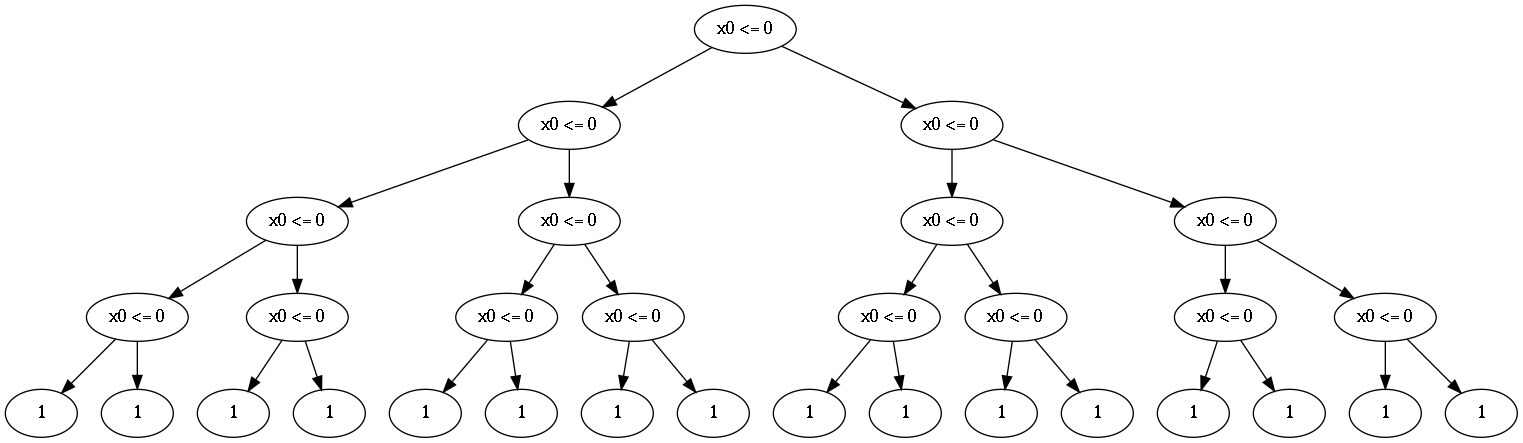

In [15]:
plot = None
if plot_tree_from_parameters != 'make_classification':
    plot = plot_tree_from_parameters(y_data_list[0][0].values, config)
plot

In [16]:
def inject_noise(y_data, noise=0.0, noise_dist='normal', seed=42):
    """
    Returns a polynomial injected with specified noise type and amount. 
    Inputs a clean polynomial array with x-data and y-data and modifies the y-data according to the noise settings.
    """
    np.random.seed(seed)
    
    #Calculate range of function values of input polynomial
    range_values_fv = np.ptp(y_data[1].values)
    
    #Selection of noise type
    #Available types: normal, uniform, A, B, C
    if noise_dist=='normal':
        noise_sample=noise*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform':
        noise_sample=noise*np.random.uniform(low=0, high=1.0,size=y_data[1].shape[0])
    elif noise_dist=='normal_range':
        #Normal distribution adjusted to function value range
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='uniform_range':
        noise_sample=(noise*range_values_fv)*np.random.normal(loc=0, scale=1.0,size=y_data[1].shape[0])
    elif noise_dist=='flip_percentage':
        idx = np.random.choice(y_data[1].shape[0], int(y_data[1].shape[0]*noise), replace=False)
        y_data[1].iloc[idx] = (y_data[1].iloc[idx] + 1) % 2 
        return y_data
    else:
        #no noise
        noise_sample = np.zeros(y_data[1].shape[0])
                               
    noise_sample=noise_sample.reshape(-1,1)
    
    y_data[1]=y_data[1]+noise_sample
    
    return np.clip(y_data, 0, 1)

In [17]:
if noise_injected_level > 0:
    parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky')
    y_data_list = parallel(delayed(inject_noise)(y_data=y_data_list[i],
                                                 noise=noise_injected_level,
                                                 noise_dist=noise_injected_type, 
                                                 seed=RANDOM_SEED+i) for i in range(len(y_data_list)))


In [18]:
y_data_list[0][0].head(10)

feat0    0
feat1    0
feat2    0
feat3    0
feat4    0
feat5    0
feat6    0
feat7    0
feat8    0
feat9    0
dtype: int64

In [19]:
y_data_list[0][0]

feat0      0
feat1      0
feat2      0
feat3      0
feat4      0
feat5      0
feat6      0
feat7      0
feat8      0
feat9      0
feat10     0
feat11     0
feat12     0
feat13     0
feat14     0
split0     0
split1     0
split2     0
split3     0
split4     0
split5     0
split6     0
split7     0
split8     0
split9     0
split10    0
split11    0
split12    0
split13    0
split14    0
lp0        0
lp1        0
lp2        0
lp3        0
lp4        0
lp5        0
lp6        0
lp7        0
lp8        0
lp9        0
lp10       0
lp11       0
lp12       0
lp13       0
lp14       0
lp15       0
dtype: int64

In [20]:
y_data_list[0][1].head(10)

,result
0,0
1,0
2,0
3,0
4,0
5,0
6,0
7,0
8,0
9,0


## Lambda Network Training + Weigh/Bias saving

In [21]:
#%load_ext autoreload

In [22]:
rand_index = np.random.randint(number_of_trained_lambda_nets)
print(rand_index)
#rand_tree = generate_decision_tree_from_array(y_data_list[rand_index][0].values, config)
#rand_tree.plot_tree()

860


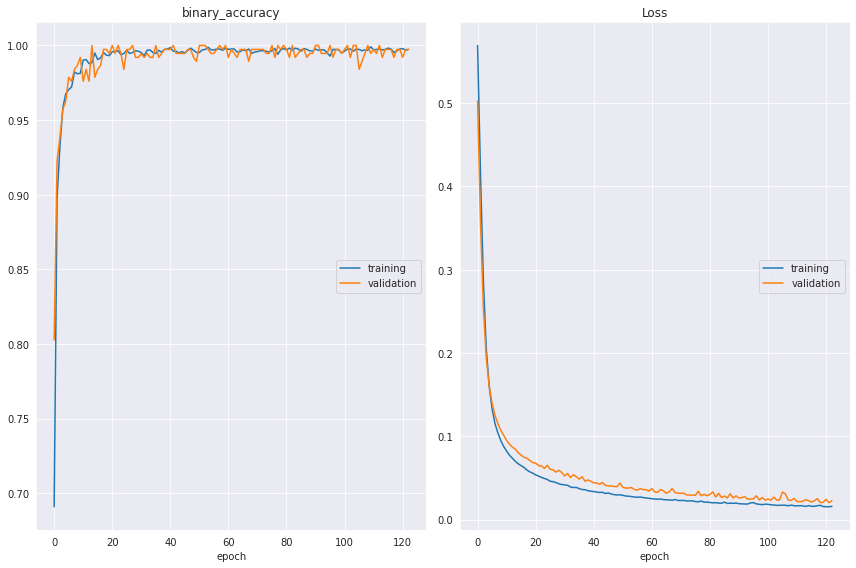

binary_accuracy
	training         	 (min:    0.691, max:    0.999, cur:    0.997)
	validation       	 (min:    0.803, max:    1.000, cur:    0.997)
Loss
	training         	 (min:    0.015, max:    0.569, cur:    0.016)
	validation       	 (min:    0.020, max:    0.502, cur:    0.023)


In [23]:
#%autoreload 2
random_network = train_lambda_net(config=config,
                                  lambda_index=rand_index, 
                                  X_data_with_function=X_data_list[rand_index], 
                                  y_data_with_function=y_data_list[rand_index], 
                                  distribution_parameter_list = distribution_parameter_list_list[rand_index][1],
                                  callbacks=[PlotLossesKerasTF()], 
                                  return_model=True,
                                  printing=False)

In [24]:
distribution_parameter_list = []
for dic in distribution_parameter_list_list[rand_index][1]:
    distribution_parameter = {}
    key_1 = list(dic.keys())[0]
    value_1 = list(dic.values())[0]
    distribution_parameter[key_1] = {'class_0': {},
                                          'class_1': {}}
    for key_2, value_2 in value_1.items():
        distribution_parameter[key_1]['class_0'][key_2] = value_2
        distribution_parameter[key_1]['class_1'][key_2] = value_2
        
    distribution_parameter_list.append(distribution_parameter)
distribution_parameter_list

[{'gamma': {'class_0': {'shape': 2.294746029848539,
    'scale': 1.8367455651993825},
   'class_1': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}}},
 {'binomial': {'class_0': {'n': 110.36098366105128, 'p': 0.5780162370331168},
   'class_1': {'n': 110.36098366105128, 'p': 0.5780162370331168}}},
 {'uniform': {'class_0': {'low': 0.031443983899839295,
    'high': 0.2471077711629195},
   'class_1': {'low': 0.031443983899839295, 'high': 0.2471077711629195}}},
 {'gamma': {'class_0': {'shape': 1.6594389392120168, 'scale': 2.1791295055931},
   'class_1': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}}},
 {'beta': {'class_0': {'a': 1.646678461218394, 'b': 4.219524404121461},
   'class_1': {'a': 1.646678461218394, 'b': 4.219524404121461}}},
 {'normal': {'class_0': {'loc': 0.46844150681168545,
    'scale': 1.130939151207969},
   'class_1': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}}},
 {'poisson': {'class_0': {'lam': 0.8353504046093533},
   'class_1': {'lam': 0.8

In [25]:
random_data_X, random_data_Y, random_data_distribution_parameter_list, _ = generate_dataset_from_distributions(None, 
                                    10, 
                                    5000, 
                                    distributions_per_class = 0, 
                                    seed = RANDOM_SEED+rand_index, 
                                    flip_percentage=0, 
                                    random_parameters=True, 
                                    distribution_dict_list=distribution_parameter_list)


In [26]:
print(random_data_X.shape[0], np.count_nonzero(np.round(random_network['model'].predict(random_data_X))))


5000 2837


{'gamma': {'class_0': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}, 'class_1': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}}}
{'binomial': {'class_0': {'n': 110.36098366105128, 'p': 0.5780162370331168}, 'class_1': {'n': 110.36098366105128, 'p': 0.5780162370331168}}}
{'uniform': {'class_0': {'low': 0.031443983899839295, 'high': 0.2471077711629195}, 'class_1': {'low': 0.031443983899839295, 'high': 0.2471077711629195}}}
{'gamma': {'class_0': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}, 'class_1': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}}}
{'beta': {'class_0': {'a': 1.646678461218394, 'b': 4.219524404121461}, 'class_1': {'a': 1.646678461218394, 'b': 4.219524404121461}}}
{'normal': {'class_0': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}, 'class_1': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}}}
{'poisson': {'class_0': {'lam': 0.8353504046093533}, 'class_1': {'lam': 0.8353504046093533}}}
{'normal': {'class_0': {'lo

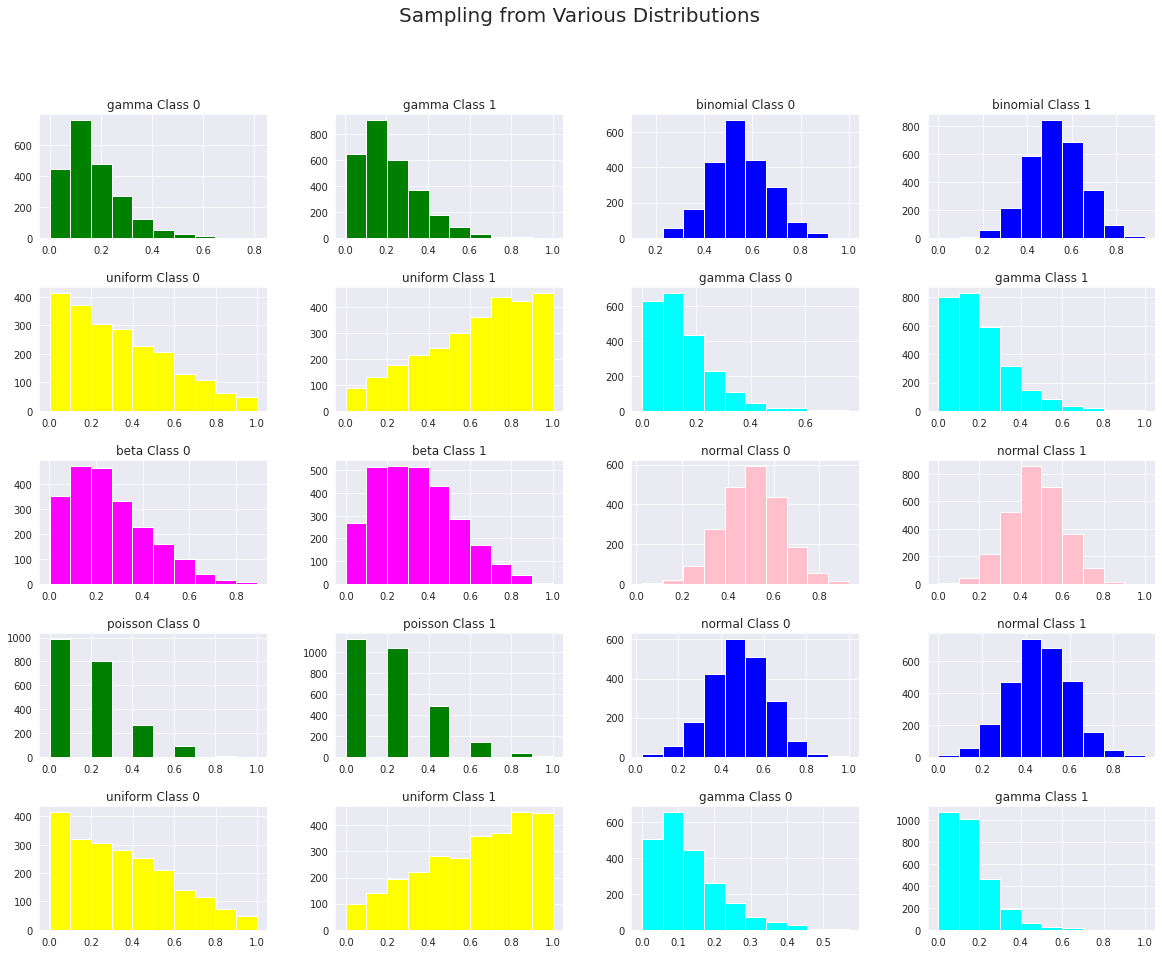

In [27]:
if True:
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=5, ncols=4,figsize=(20,15))
    plot_index = 0

    for i in range(random_data_X.shape[1]):
        distribution_parameter = random_data_distribution_parameter_list[i]
        print(distribution_parameter)
        colors = colors_list[i%6]

        x = random_data_X[:,i][np.where(random_network['model'].predict(random_data_X).ravel()<=0.5)]
        plt.subplot(5,4,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = random_data_X[:,i][np.where(random_network['model'].predict(random_data_X).ravel()>0.5)]
        plt.subplot(5,4,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

In [28]:
print(X_data_list[rand_index][1].shape[0], np.count_nonzero(np.round(random_network['model'].predict(X_data_list[rand_index][1]))))



5000 2506


{'gamma': {'class_0': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}, 'class_1': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}}}
{'binomial': {'class_0': {'n': 110.36098366105128, 'p': 0.5780162370331168}, 'class_1': {'n': 110.36098366105128, 'p': 0.5780162370331168}}}
{'uniform': {'class_0': {'low': 0.031443983899839295, 'high': 0.2471077711629195}, 'class_1': {'low': 0.031443983899839295, 'high': 0.2471077711629195}}}
{'gamma': {'class_0': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}, 'class_1': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}}}
{'beta': {'class_0': {'a': 1.646678461218394, 'b': 4.219524404121461}, 'class_1': {'a': 1.646678461218394, 'b': 4.219524404121461}}}
{'normal': {'class_0': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}, 'class_1': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}}}
{'poisson': {'class_0': {'lam': 0.8353504046093533}, 'class_1': {'lam': 0.8353504046093533}}}
{'normal': {'class_0': {'lo

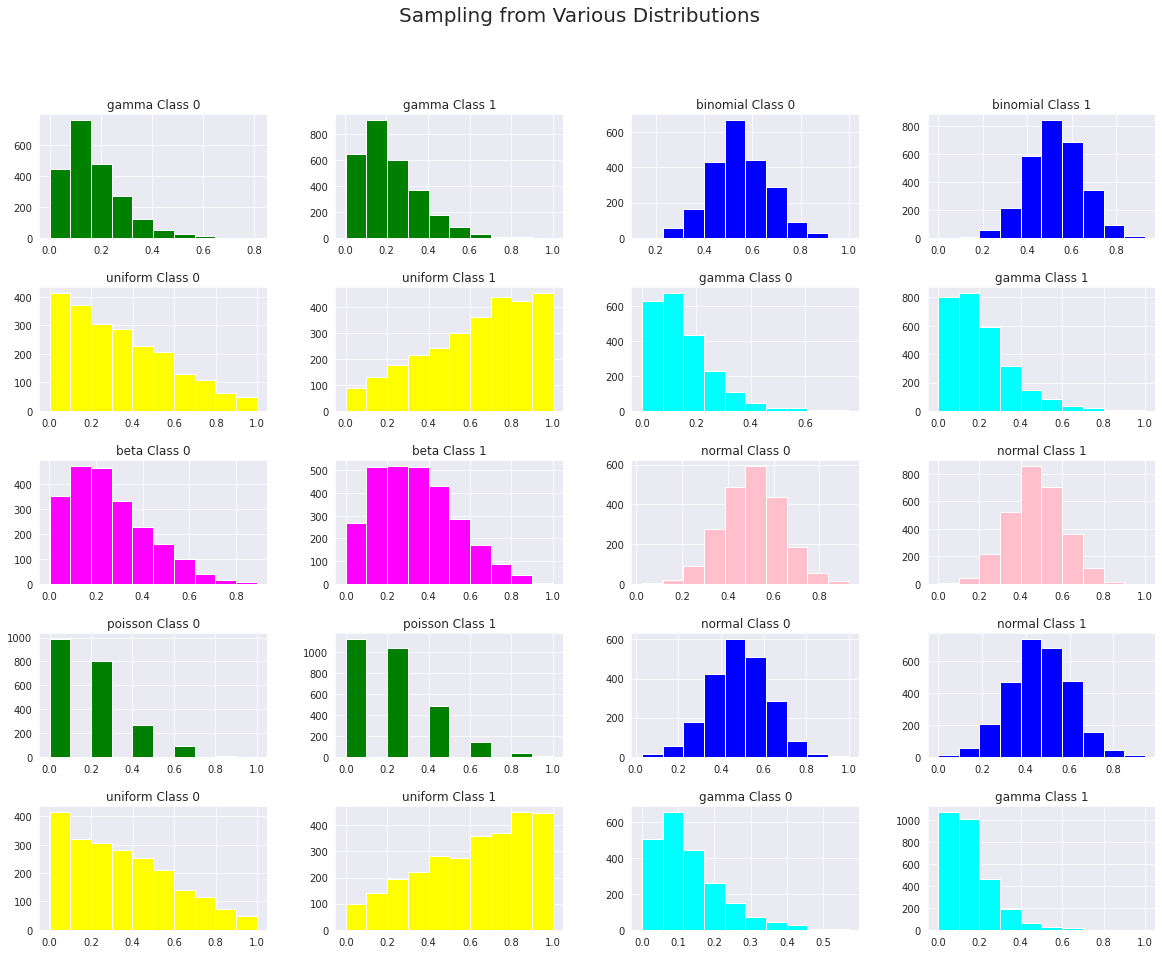

In [29]:
if True:
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=5, ncols=4,figsize=(20,15))
    plot_index = 0

    for i in range(random_data_X.shape[1]):
        distribution_parameter = random_data_distribution_parameter_list[i]
        print(distribution_parameter)
        colors = colors_list[i%6]

        x = random_data_X[:,i][np.where(random_network['model'].predict(random_data_X).ravel()<=0.5)]
        plt.subplot(5,4,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 0' )
        plot_index += 1

        x = random_data_X[:,i][np.where(random_network['model'].predict(random_data_X).ravel()>0.5)]
        plt.subplot(5,4,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0] + ' Class 1' )
        plot_index += 1

    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

{'gamma': {'class_0': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}, 'class_1': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}}}
{'binomial': {'class_0': {'n': 110.36098366105128, 'p': 0.5780162370331168}, 'class_1': {'n': 110.36098366105128, 'p': 0.5780162370331168}}}
{'uniform': {'class_0': {'low': 0.031443983899839295, 'high': 0.2471077711629195}, 'class_1': {'low': 0.031443983899839295, 'high': 0.2471077711629195}}}
{'gamma': {'class_0': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}, 'class_1': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}}}
{'beta': {'class_0': {'a': 1.646678461218394, 'b': 4.219524404121461}, 'class_1': {'a': 1.646678461218394, 'b': 4.219524404121461}}}
{'normal': {'class_0': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}, 'class_1': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}}}
{'poisson': {'class_0': {'lam': 0.8353504046093533}, 'class_1': {'lam': 0.8353504046093533}}}
{'normal': {'class_0': {'lo

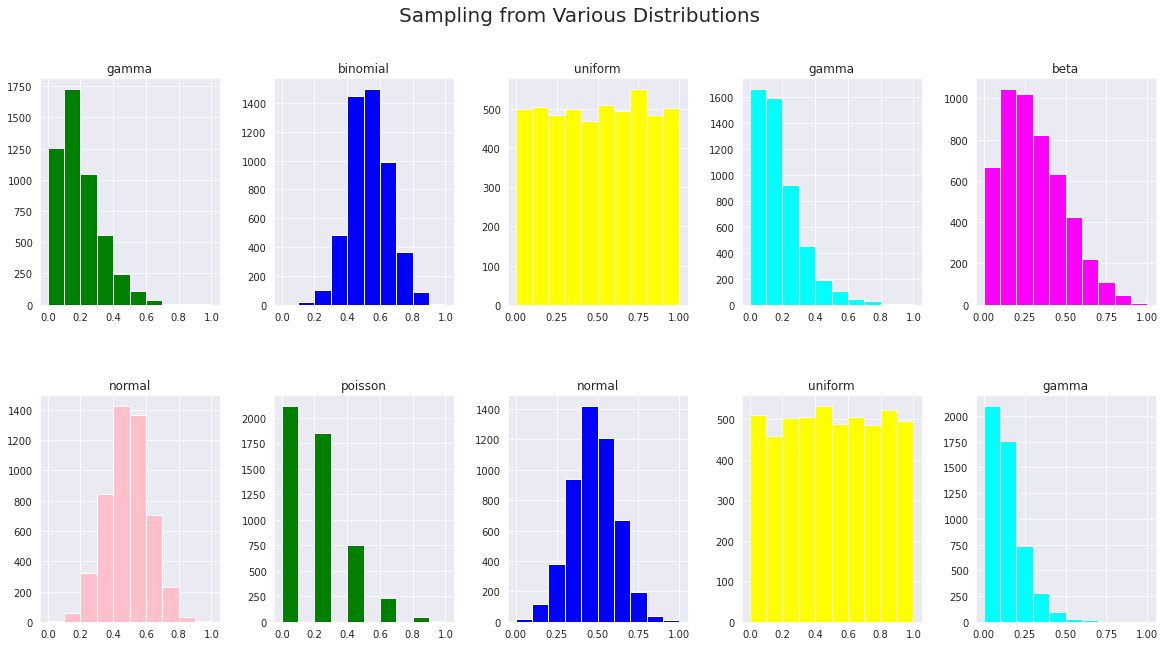

In [33]:
if True:
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))
    plot_index = 0

    for i in range(X_data_list[rand_index][1].shape[1]):
        distribution_parameter = distribution_parameter_list[i]
        print(distribution_parameter)
        colors = colors_list[i%6]

        x = X_data_list[rand_index][1].values[:,i]
        plt.subplot(2,5,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0])
        plot_index += 1


    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

{'gamma': {'class_0': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}, 'class_1': {'shape': 2.294746029848539, 'scale': 1.8367455651993825}}}
{'binomial': {'class_0': {'n': 110.36098366105128, 'p': 0.5780162370331168}, 'class_1': {'n': 110.36098366105128, 'p': 0.5780162370331168}}}
{'uniform': {'class_0': {'low': 0.031443983899839295, 'high': 0.2471077711629195}, 'class_1': {'low': 0.031443983899839295, 'high': 0.2471077711629195}}}
{'gamma': {'class_0': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}, 'class_1': {'shape': 1.6594389392120168, 'scale': 2.1791295055931}}}
{'beta': {'class_0': {'a': 1.646678461218394, 'b': 4.219524404121461}, 'class_1': {'a': 1.646678461218394, 'b': 4.219524404121461}}}
{'normal': {'class_0': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}, 'class_1': {'loc': 0.46844150681168545, 'scale': 1.130939151207969}}}
{'poisson': {'class_0': {'lam': 0.8353504046093533}, 'class_1': {'lam': 0.8353504046093533}}}
{'normal': {'class_0': {'lo

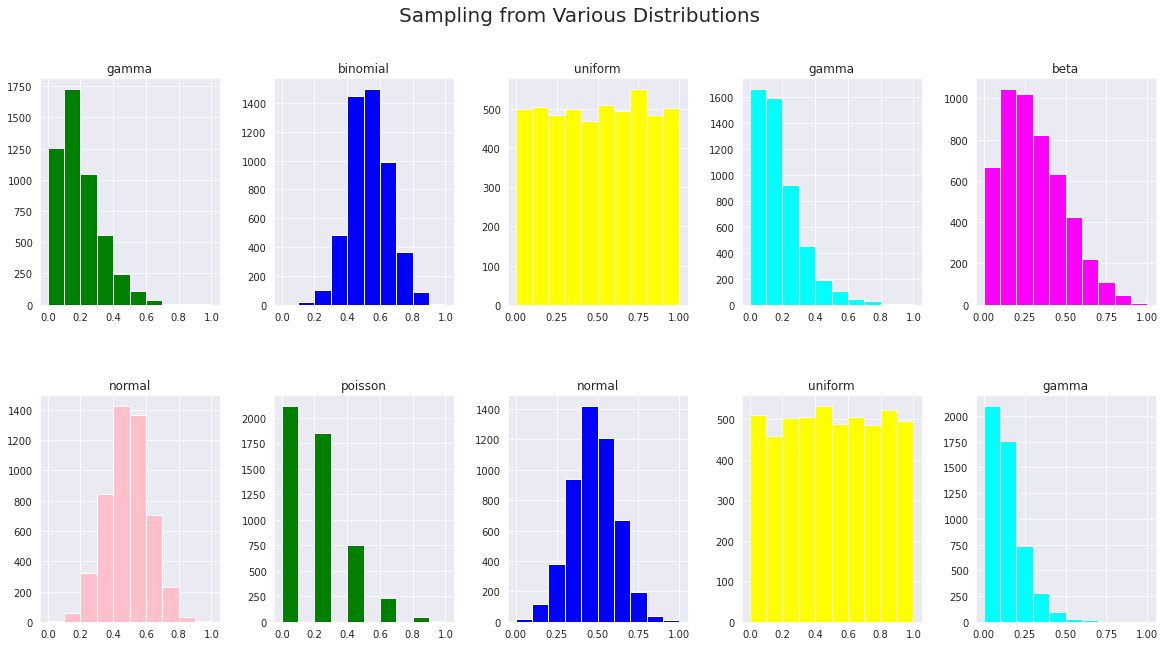

In [34]:
if True:
    colors_list = ['green','blue','yellow','cyan','magenta','pink']

    fig,ax = plt.subplots(nrows=2, ncols=5,figsize=(20,10))
    plot_index = 0

    for i in range(X_data_list[rand_index][1].shape[1]):
        distribution_parameter = distribution_parameter_list[i]
        print(distribution_parameter)
        colors = colors_list[i%6]

        x = X_data_list[rand_index][1].values[:,i]
        plt.subplot(2,5,plot_index+1)
        plt.hist(x,bins=10,color=colors)
        plt.title(list(distribution_parameter.keys())[0])
        plot_index += 1


    fig.subplots_adjust(hspace=0.4,wspace=.3) 
    plt.suptitle('Sampling from Various Distributions',fontsize=20)
    plt.show()

In [32]:
zzzzzzzz

NameError: name 'zzzzzzzz' is not defined

In [ ]:
#%autoreload 2
parallel = Parallel(n_jobs=n_jobs, verbose=3, backend='loky') #loky
clf_list = parallel(delayed(train_lambda_net)(config=config,
                                              lambda_index=index, 
                                              X_data_with_function=X_data, 
                                              y_data_with_function=y_data,
                                              distribution_parameter_list=distribution_parameter_list[1],
                                              return_history=True, 
                                              printing=True) for index, (X_data, y_data, distribution_parameter_list) in enumerate(zip(X_data_list, y_data_list, distribution_parameter_list_list)))  
del parallel

In [ ]:
random_network['model'].get_config()

In [ ]:
random_network['model'].summary()

## Save and Plot Lambda-Model History

In [ ]:
loss_list_total = []
metric_list_total = []

val_loss_list_total = []
val_metric_list_total = []

index_list = []


max_training_epochs = 0
for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    max_training_epochs = max(max_training_epochs, current_training_epochs)


for _, entry in tqdm(enumerate(clf_list)):
    history = entry['history']
    index = entry['index']
    
    current_training_epochs = len(history[list(history.keys())[0]])
    
    loss_list = np.full(max_training_epochs, np.nan)
    metric_list = np.full(max_training_epochs, np.nan)
    val_loss_list = np.full(max_training_epochs, np.nan)
    val_metric_list = np.full(max_training_epochs, np.nan) 

    for i in range(current_training_epochs):  
        loss_list[i] = history[list(history.keys())[0]][i]
        metric_list[i] = history[list(history.keys())[1]][i]
        val_loss_list[i] = history[list(history.keys())[len(history.keys())//2]][i]
        val_metric_list[i] = history[list(history.keys())[len(history.keys())//2+1]][i]
    
    index_list.append([index])
    loss_list_total.append(loss_list)
    metric_list_total.append(metric_list)
    val_loss_list_total.append(val_loss_list)
    val_metric_list_total.append(val_metric_list)

loss_df = pd.DataFrame(data=np.hstack([index_list, loss_list_total]), columns=flatten_list(['index', [list(history.keys())[0] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#loss_df['index'] = loss_df['index'].astype(int)
metric_df = pd.DataFrame(data=np.hstack([index_list, metric_list_total]), columns=flatten_list(['index', [list(history.keys())[1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#metric_df['index'] = metric_df['index'].astype(int)
val_loss_df = pd.DataFrame(data=np.hstack([index_list, val_loss_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]]))
#val_loss_df['index'] = val_loss_df['index'].astype(int)
val_metric_df = pd.DataFrame(data=np.hstack([index_list, val_metric_list_total]), columns=flatten_list(['index', [list(history.keys())[len(history.keys())//2+1] + '_epoch_' + str(i+1) for i in range(max_training_epochs)]])) 
#val_metric_df['index'] = val_metric_df['index'].astype(int)


In [ ]:
path_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[0] + '.txt'
path_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[1] + '.txt'
path_val_loss = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2] + '.txt'
path_val_metric = './data/weights/weights_' + path_identifier_lambda_net_data + '/history_' + list(history.keys())[len(history.keys())//2+1] + '.txt'

loss_df.to_csv(path_loss, index=None, sep=',')
metric_df.to_csv(path_metric, index=None, sep=',')
val_loss_df.to_csv(path_val_loss, index=None, sep=',')
val_metric_df.to_csv(path_val_metric, index=None, sep=',')


In [ ]:
loss_df.describe()

In [ ]:
val_loss_df.describe()

In [ ]:
metric_df.describe()

In [ ]:
val_metric_df.describe()

In [ ]:
# summarize history for metric
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[1] + '.png'

adjustment_threshold_metric = 10#100
    
metric_df_adjusted = metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    metric_df_adjusted[metric_df_adjusted.columns] = np.where(metric_df_adjusted[metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, metric_df_adjusted[metric_df_adjusted.columns])
    
val_metric_df_adjusted = val_metric_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_metric > 0:
    val_metric_df_adjusted[val_metric_df_adjusted.columns] = np.where(val_metric_df_adjusted[val_metric_df_adjusted.columns] > adjustment_threshold_metric, adjustment_threshold_metric, val_metric_df_adjusted[val_metric_df_adjusted.columns])

    
plt.plot(metric_df_adjusted.describe().loc['mean'].values)
plt.plot(val_metric_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[1])
plt.ylabel(list(history.keys())[1])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
# summarize history for loss
path = './data/results/weights_' + path_identifier_lambda_net_data + '/' + list(history.keys())[0] + '.png'

adjustment_threshold_loss = 0#10000
    
loss_df_adjusted = loss_df.copy(deep=True).iloc[:,1:]

if adjustment_threshold_loss > 0:
    loss_df_adjusted[loss_df_adjusted.columns] = np.where(loss_df_adjusted[loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, loss_df_adjusted[loss_df_adjusted.columns])
    
val_loss_df_adjusted = val_loss_df.copy(deep=True).iloc[:,1:]
if adjustment_threshold_loss > 0:
    val_loss_df_adjusted[val_loss_df_adjusted.columns] = np.where(val_loss_df_adjusted[val_loss_df_adjusted.columns] > adjustment_threshold_loss, adjustment_threshold_loss, val_loss_df_adjusted[val_loss_df_adjusted.columns])

    
plt.plot(loss_df_adjusted.describe().loc['mean'].values)
plt.plot(val_loss_df_adjusted.describe().loc['mean'].values)
plt.title('model ' + list(history.keys())[0])
plt.ylabel(list(history.keys())[0])
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.savefig(path)
plt.show()


In [ ]:
print('a')